<a href="https://colab.research.google.com/github/KevinTheRainmaker/Bio-medical-AI/blob/main/Covid_CT_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid CT Image Classification

## 해결해야 할 문제
### Data Imabalance
의료 데이터는 매우 imbalance한 class 분포를 갖는 경우가 많다. 이 때문에 단순 Accuracy로는 충분한 성능 입증을 하기 어렵다.

> ROC Curve & Precision-Recall Curve / F1 Score 이용

> ![image](https://user-images.githubusercontent.com/76294398/216822915-c64fa67c-d3ef-4386-9889-3eeea8dab9f1.png)

* 참고: Precision은 FP가 적을수록, Recall은 FN이 적을수록 높게 나타난다. 


## Data load & Visualize samples

Original Data Source: https://github.com/UCSD-AI4H/COVID-CT

Related Paper: https://arxiv.org/pdf/2003.13865.pdf

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q /content/drive/MyDrive/data/Covid_Dataset.zip

In [3]:
!ls

Covid_Dataset  drive  __MACOSX	sample_data


In [4]:
root_dir = '/content/Covid_Dataset/'

In [5]:
import random
import os
import cv2
import matplotlib.pyplot as plt

In [6]:
train_path = os.path.join(root_dir, 'Covid_Train')
normal_path = os.path.join(train_path, '0_CT_NonCOVID')
covid_path = os.path.join(train_path, '1_CT_COVID')

normal_files = [os.path.join(normal_path, x) for x in os.listdir(normal_path)]
normal_samples = [cv2.imread(x) for x in random.sample(normal_files, 5)]

covid_files = [os.path.join(covid_path, x) for x in os.listdir(covid_path)]
covid_samples = [cv2.imread(x) for x in random.sample(covid_files, 5)]

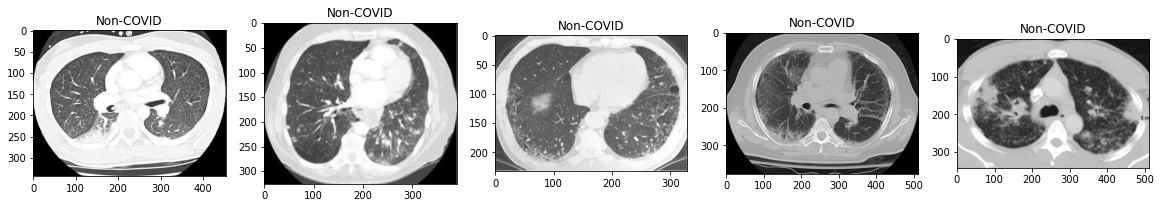

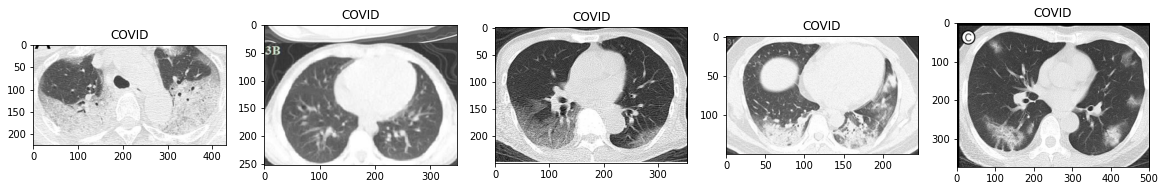

In [7]:
# Non-COVID
plt.figure(figsize=(20,10))
columns = 5

for i, image in enumerate(normal_samples):
  plt.subplot(len(normal_samples) / columns+1, columns, i+1)
  plt.title('Non-COVID')
  plt.imshow(image)

# COVID
plt.figure(figsize=(20,10))
columns = 5

for i, image in enumerate(covid_samples):
  plt.subplot(len(covid_samples) / columns+1, columns, i+1)
  plt.title('COVID')
  plt.imshow(image)

## EDA

In [8]:
def print_files_in_dir(root_dir, prefix):
  files = os.listdir(root_dir)
  label = ['COVID', 'Non-COVID']
  for i, file in enumerate(files):
    path = os.path.join(root_dir, file)
    file_list = os.listdir(path)
    print(f'{prefix} 데이터의 {label[i]} sample 수: {len(file_list)}')

In [9]:
phase = ['Train','Valid','Test']
print_files_in_dir(root_dir+f'Covid_{phase[0]}', phase[0])
print()
print_files_in_dir(root_dir+f'Covid_{phase[1]}', phase[1])
print()
print_files_in_dir(root_dir+f'Covid_{phase[2]}', phase[2])

Train 데이터의 COVID sample 수: 191
Train 데이터의 Non-COVID sample 수: 234

Valid 데이터의 COVID sample 수: 60
Valid 데이터의 Non-COVID sample 수: 58

Test 데이터의 COVID sample 수: 98
Test 데이터의 Non-COVID sample 수: 105


## Data preprocessing & Build DataLoader

In [10]:
import numpy as np
import torch
import torch.utils.data as data
from torchvision import datasets, transforms

In [13]:
# device setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Current device: {device}')

# set random seed for reproductibility
random_seed = 2023
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Avoid non-deterministic 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Current device: cuda


PyTorch Reproductivity 설정 관련 reference: https://tempdev.tistory.com/28

In [14]:
# Data transform

normalize = transforms.Normalize(mean=[0,0,0], std=[1,1,1])
image_transforms = {
    'train': 
    transforms.Compose([
        transforms.Resize(256),
    
        # data augmentation
        transforms.RandomResizedCrop((224), scale=(0.5,1.0)),
        transforms.RandomHorizontalFlip(),

        transforms.ToTensor(),
        normalize
        ]),

    'valid':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
        ])
}

In [15]:
train_dataset_folder = root_dir + 'Covid_Train'
valid_dataset_folder = root_dir + 'Covid_Valid'
test_dataset_folder = root_dir + 'Covid_Test'

In [16]:
train_dataset = datasets.ImageFolder(root=train_dataset_folder, transform=image_transforms['train'])
valid_dataset = datasets.ImageFolder(root=valid_dataset_folder, transform=image_transforms['valid'])
test_dataset = datasets.ImageFolder(root=test_dataset_folder, transform=image_transforms['valid']) # test_dataset은 valid와 같은 transform 적용

In [17]:
# Parameters for DataLoader

train_params = {
    'batch_size':64,
    'shuffle':True,
    'num_workers':1,
    'drop_last':False
}

valid_params = {
    'batch_size':64,
    'shuffle':False,
    'num_workers':1,
    'drop_last':False
}

DataLoader paramter 용도 reference: https://subinium.github.io/pytorch-dataloader/

In [18]:
train_loader = data.DataLoader(train_dataset, **train_params)
valid_loader = data.DataLoader(valid_dataset, **valid_params)
test_loader = data.DataLoader(test_dataset, **valid_params)

In [19]:
# DataLoader 동작 확인
for x,y in train_loader:
  print(x.shape)
  print(y.shape)
  break

for x,y in valid_loader:
  print(x.shape)
  print(y.shape)
  break

for x,y in test_loader:
  print(x.shape)
  print(y.shape)
  break

torch.Size([64, 3, 224, 224])
torch.Size([64])
torch.Size([64, 3, 224, 224])
torch.Size([64])
torch.Size([64, 3, 224, 224])
torch.Size([64])


## Model

In [23]:
from torchvision import models # 모델을 직접 구현하지 않고도 pre-trained model 사용 가능
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [25]:
# Parameters for Model

cfg = {
    'cls_hid_dims':[1024, 512, 256]
}

In [33]:
# feature extractor
class CovidResNet(nn.Module):
  def __init__(self):
    '''
    Args:
      base_model : resnet18 / resnet50
      config : 모델 설정 값
    '''
    super().__init__()
    model = models.resnet50(pretrained=True)
    num_features = model.fc.in_features
    self.num_features = num_features

    for name, param in model.named_parameters():
      if 'layer2' in name:
        break # layer1만 이용
      param.requires_grad = False # grad 고정 (train 하지 않음)

    self.features = nn.Sequential(*list(model.children())[:-1]) # 마지막 classifier 부분 제외
  
  def forward(self, x):
    x = self.features(x)
    b = x.size(0)
    x = x.view(b, -1)
    print('########', x.size())
    return x